In [ ]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/yenidataset_split.zip"

dest_dir = "/content/yenidataset_split3"

import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dest_dir)

print(f"✅ {zip_path} içeriği {dest_dir} klasörüne çıkarıldı.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ /content/drive/MyDrive/yenidataset_split.zip içeriği /content/yenidataset_split3 klasörüne çıkarıldı.


In [ ]:
import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import timm

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
# ─── 1️⃣ CONFIG ────────────────────────────────────────────────────────────────
EPOCHS       = 30
BATCH_SIZE   = 32
IMG_SIZE     = 224
NUM_CLASSES  = 5
DATA_PATH    = "/content/yenidataset_split3/yenidataset_split"
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED         = 42
LR           = 1e-5
WEIGHT_DECAY = 2e-2
# ────────────────────────────────────────────────────────────────────────────────

# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if DEVICE.type == 'cuda':
    torch.cuda.manual_seed(SEED)


In [ ]:
# ─── 2️⃣ TRANSFORMS ─────────────────────────────────────────────────────────────
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.2),
    transforms.RandomPerspective(distortion_scale=0.4, p=0.5),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [ ]:
# ─── 3️⃣ DATASETS & DATALOADERS ───────────────────────────────────────────────
train_ds = ImageFolder(os.path.join(DATA_PATH, "train"), transform=train_transform)
val_ds   = ImageFolder(os.path.join(DATA_PATH, "val"),   transform=val_transform)
test_ds  = ImageFolder(os.path.join(DATA_PATH, "test"),  transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)

In [ ]:
# ─── 4️⃣ MODEL, LOSS, OPTIMIZER & SCHEDULER ─────────────────────────────────────
model = timm.create_model(
    'swin_tiny_patch4_window7_224',
    pretrained=True,
    num_classes=NUM_CLASSES,
    drop_rate=0.5,
    drop_path_rate=0.3
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# ✅ CosineAnnealingLR (instead of ReduceLROnPlateau)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# ✅ Mixup Function
def mixup_data(x, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(DEVICE)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [ ]:
# ─── 5️⃣ TRAIN + VALIDATION ──────────────────────────────────────────────────
train_losses, val_losses = [], []

t0 = time.time()
for epoch in range(1, EPOCHS+1):
    t_epoch = time.time()

    # — Train —
    model.train()
    run_train = 0.0
    for imgs, lbls in tqdm(train_loader, desc=f"Train {epoch}/{EPOCHS}", leave=False):
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)

        # ✅ Mixup kullanımı
        inputs, targets_a, targets_b, lam = mixup_data(imgs, lbls, alpha=0.4)

        optimizer.zero_grad()
        out = model(inputs)
        loss = lam * criterion(out, targets_a) + (1 - lam) * criterion(out, targets_b)
        loss.backward()
        optimizer.step()
        run_train += loss.item()
    train_loss = run_train / len(train_loader)
    train_losses.append(train_loss)

    # — Validation —
    model.eval()
    run_val = 0.0
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            out = model(imgs)
            val_loss_batch = criterion(out, lbls)
            run_val += val_loss_batch.item()
    val_loss = run_val / len(val_loader)
    val_losses.append(val_loss)

    # ✅ Scheduler Update
    scheduler.step()

    print(f"Epoch {epoch}/{EPOCHS} — {(time.time()-t_epoch):.1f}s | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

# Final model save after all epochs
torch.save(model.state_dict(), "final_swin_model.pth")
print(f"\n🏁 Training completed in {(time.time()-t0)/60:.1f}m")

Epoch 1/30 — 120.5s | Train: 1.5073 | Val: 1.2377


Epoch 2/30 — 121.0s | Train: 1.3634 | Val: 1.1767


Epoch 3/30 — 121.2s | Train: 1.3168 | Val: 1.1422


Epoch 4/30 — 121.1s | Train: 1.3077 | Val: 1.1314


Epoch 5/30 — 121.0s | Train: 1.2818 | Val: 1.1131


Epoch 6/30 — 120.7s | Train: 1.2692 | Val: 1.1041


Epoch 7/30 — 120.4s | Train: 1.2586 | Val: 1.0995


Epoch 8/30 — 120.4s | Train: 1.2510 | Val: 1.0971


Epoch 9/30 — 120.2s | Train: 1.2561 | Val: 1.0856


Epoch 10/30 — 120.3s | Train: 1.2428 | Val: 1.0841


Epoch 11/30 — 120.2s | Train: 1.2299 | Val: 1.0955


Epoch 12/30 — 120.0s | Train: 1.2359 | Val: 1.0737


Epoch 13/30 — 120.1s | Train: 1.2270 | Val: 1.0747


Epoch 14/30 — 120.1s | Train: 1.2093 | Val: 1.0795


Epoch 15/30 — 120.1s | Train: 1.2133 | Val: 1.0946


Epoch 16/30 — 120.2s | Train: 1.2220 | Val: 1.0733


Epoch 17/30 — 120.2s | Train: 1.2038 | Val: 1.0734


Epoch 18/30 — 121.3s | Train: 1.2032 | Val: 1.0718


Epoch 19/30 — 121.6s | Train: 1.1918 | Val: 1.0688


Epoch 20/30 — 121.1s | Train: 1.2032 | Val: 1.0696


Epoch 21/30 — 121.1s | Train: 1.2031 | Val: 1.0708


Epoch 22/30 — 121.3s | Train: 1.1969 | Val: 1.0703


Epoch 23/30 — 121.1s | Train: 1.2004 | Val: 1.0689


Epoch 24/30 — 120.3s | Train: 1.1898 | Val: 1.0705


Epoch 25/30 — 120.2s | Train: 1.1938 | Val: 1.0665


Epoch 26/30 — 120.1s | Train: 1.2027 | Val: 1.0695


Epoch 27/30 — 120.0s | Train: 1.1862 | Val: 1.0689


Epoch 28/30 — 120.1s | Train: 1.1770 | Val: 1.0691


Epoch 29/30 — 120.2s | Train: 1.1859 | Val: 1.0687


Epoch 30/30 — 119.9s | Train: 1.1906 | Val: 1.0687

🏁 Training completed in 60.3m, best_val_loss=1.0665


Test Inference: 100%|██████████| 62/62 [00:06<00:00,  9.40it/s]



Final Test Metrics:
 • Accuracy       : 0.6164
 • Precision (M)  : 0.6186
 • Recall    (M)  : 0.6172
 • F1-Score  (M)  : 0.6154
 • AUC-micro      : 0.8721
 • AUC-macro      : 0.8640
 • Sensitivity (M): 0.6172
 • Specificity (M): 0.9041
 • Train Time     : 4655.2s
 • Inference Time : 6.6s


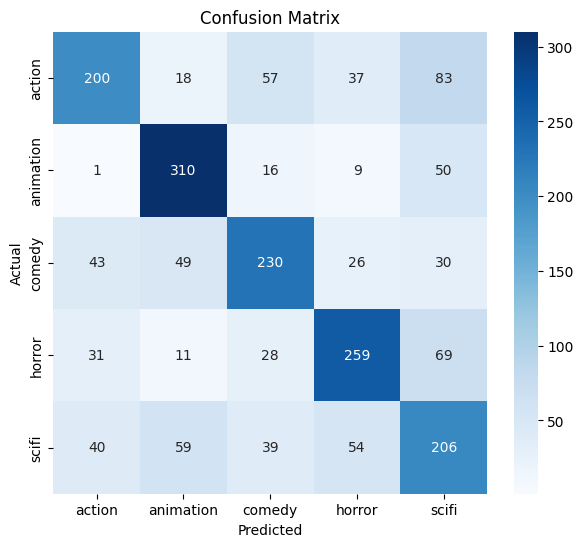

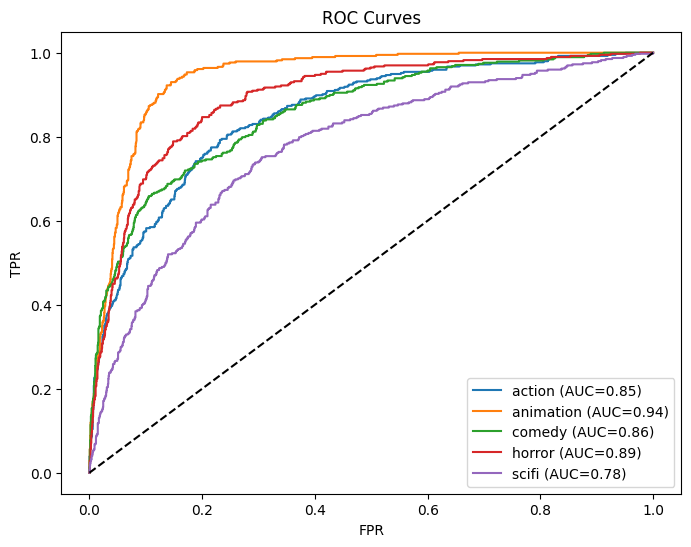

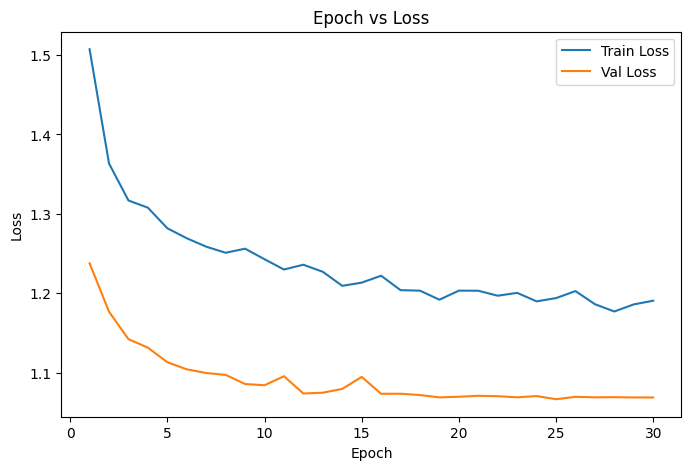

In [ ]:
# ─── 6️⃣ LOAD BEST MODEL & FINAL TEST EVALUATION ────────────────────────────────
model.load_state_dict(torch.load("final_swin_model.pth"))
model.eval()

all_labels, all_preds, all_probs = [], [], []
t_inf = time.time()
with torch.no_grad():
    for imgs, lbls in tqdm(test_loader, desc="Test Inference"):
        imgs = imgs.to(DEVICE)
        out  = model(imgs)
        probs = torch.softmax(out, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(lbls.numpy())
inf_time = time.time() - t_inf

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)
all_probs  = np.array(all_probs)

# ─── 7️⃣ METRICS ───────────────────────────────────────────────────────────────
conf = confusion_matrix(all_labels, all_preds)
acc   = accuracy_score(all_labels, all_preds)
prec  = precision_score(all_labels, all_preds, average='macro')
rec   = recall_score(all_labels, all_preds, average='macro')
f1    = f1_score(all_labels, all_preds, average='macro')
auc_m = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='micro')
auc_M = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')

# Specificity (macro)
specs = []
for i in range(NUM_CLASSES):
    TP = conf[i,i]
    FN = conf[i,:].sum() - TP
    FP = conf[:,i].sum() - TP
    TN = conf.sum() - TP - FN - FP
    specs.append(TN / (TN + FP))
spec_macro = np.mean(specs)

print(f"\nFinal Test Metrics:")
print(f" • Accuracy       : {acc:.4f}")
print(f" • Precision (M)  : {prec:.4f}")
print(f" • Recall    (M)  : {rec:.4f}")
print(f" • F1-Score  (M)  : {f1:.4f}")
print(f" • AUC-micro      : {auc_m:.4f}")
print(f" • AUC-macro      : {auc_M:.4f}")
print(f" • Sensitivity (M): {rec:.4f}")
print(f" • Specificity (M): {spec_macro:.4f}")
print(f" • Train Time     : {(time.time()-t0):.1f}s")
print(f" • Inference Time : {inf_time:.1f}s")

# ─── 8️⃣ PLOTS ───────────────────────────────────────────────────────────────
plt.figure(figsize=(7,6))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_ds.classes, yticklabels=test_ds.classes)
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

plt.figure(figsize=(8,6))
fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(test_ds.classes):
    fpr[i], tpr[i], _ = roc_curve((all_labels==i).astype(int), all_probs[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--'); plt.title("ROC Curves"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1),   val_losses,   label='Val Loss')
plt.title("Epoch vs Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

In [ ]:
# 1️⃣1️⃣ Model Kaydetme
save_path = "swin_model.pth"
torch.save(model.state_dict(), save_path)
print(f"\n✅ Model kaydedildi: {save_path}")